### Import lib

In [214]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import spacy
from bs4 import BeautifulSoup
import unicodedata
import string

from sklearn.model_selection import train_test_split



import re
import nltk
from nltk.tokenize import ToktokTokenizer
nltk.download('stopwords')
nltk.download('wordnet')

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.layers import Embedding,Bidirectional,Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [215]:
RANDOM_SEED = 39
np.random.seed(RANDOM_SEED)

### loading data

In [216]:
data = pd.read_json("./data/Sarcasm_Headlines_Dataset.json",lines=True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Exploratory data analysis

In [217]:
print("--------is any missing value---------- \n", data.isna().sum())

--------is any missing value---------- 
 article_link    0
headline        0
is_sarcastic    0
dtype: int64


In [218]:
data.columns

Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')

In [219]:
### drop article_link
data.drop(["article_link"],inplace=True,axis=1)
data.columns

Index(['headline', 'is_sarcastic'], dtype='object')

In [220]:
print("----- data shape ---- \n",data.shape)

----- data shape ---- 
 (26709, 2)


In [221]:
data.drop_duplicates(inplace=True)
print("----- data shape ---- \n",data.shape) ### arround 100 dublicate records have been removed

----- data shape ---- 
 (26602, 2)


----- data shape ---- 
 0    14951
1    11651
Name: is_sarcastic, dtype: int64


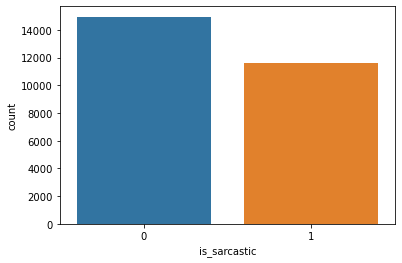

In [222]:
### distribution of sarcastic and or not
sns.countplot(data = data,x="is_sarcastic")
print("----- data shape ---- \n",data["is_sarcastic"].value_counts()) 

----- data shape ---- 
 0    11951
1    11651
Name: is_sarcastic, dtype: int64


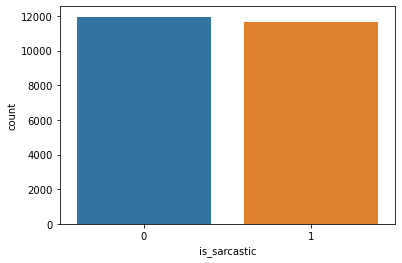

In [223]:
# count of non sarcastic is slightely greater than sarcastic - better to balace the data

data.drop(data[data["is_sarcastic"] == 0].sample(n=3000,random_state=RANDOM_SEED).index,inplace=True)

sns.countplot(data = data,x="is_sarcastic")
print("----- data shape ---- \n",data["is_sarcastic"].value_counts()) 

#### Text processing

In [224]:
#### Text Processing

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stemmer = nltk.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()


def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_numbers(text):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def remove_punctuation(text):
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

def remove_extra_whitespace_tabs(text):
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

def to_lowercase(text):
    return text.lower()


def remove_stopwords(text):
    # convert sentence into token of words
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    # check in lowercase 
    t = [token for token in tokens if token.lower() not in stopword_list]
    text = ' '.join(t)    
    return text

def get_stem(text):
    stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

def get_lem(text):
    text = ' '.join([lem.lemmatize(word) for word in text.split()])
    return text

In [225]:
def text_processing(text):
    text = to_lowercase(text)
    text = remove_html_tags(text)
    text = remove_accented_chars(text)
    text = remove_special_characters(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = remove_extra_whitespace_tabs(text)
    text = get_stem(text)
    text = get_lem(text)
    text = remove_stopwords(text)
    return text
    
data["headline_impute"] = data["headline"].apply(text_processing)    
data.head()   

,headline,is_sarcastic,headline_impute
0,former versace store clerk sues over secret 'b...,0,former versac store clerk sue secret black cod...
1,the 'roseanne' revival catches up to our thorn...,0,roseann reviv catch thorni polit mood better wors
2,mom starting to fear son's web series closest ...,1,mom start fear son web seri closest thing gran...
3,"boehner just wants wife to listen, not come up...",1,boehner want wife listen come altern debtreduc...
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowl wish snape happi birthday magic way


In [226]:
data.drop(["headline"],inplace=True,axis=1)
data.head()   

,is_sarcastic,headline_impute
0,0,former versac store clerk sue secret black cod...
1,0,roseann reviv catch thorni polit mood better wors
2,1,mom start fear son web seri closest thing gran...
3,1,boehner want wife listen come altern debtreduc...
4,0,jk rowl wish snape happi birthday magic way


In [227]:
data["sentence_length"] =  data["headline_impute"].apply(lambda x:len(text_to_word_sequence(x)))
data["sentence_length"].describe()

count    23602.000000
mean         7.149903
std          2.323282
min          1.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         26.000000
Name: sentence_length, dtype: float64

### Model parameters

In [228]:
max_length = 26 # from sentence length
voc_size = 10000
embeddding_size = 100

In [229]:
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(data['headline_impute'])

In [230]:
### original txt and text from word index
word_index = tokenizer.word_index
word_index_rev = dict(zip(word_index.values(), word_index.keys()))
print("original text ---",data["headline_impute"][0])
print("word index ---",tokenizer.texts_to_sequences([data["headline_impute"][0]]))
print("text from word index--",[word_index_rev.get(i) for i in tokenizer.texts_to_sequences([data["headline_impute"][0]])[0]])


original text --- former versac store clerk sue secret black code minor shopper
word index --- [[346, 9768, 606, 2676, 1203, 262, 72, 1827, 1337, 3035]]
text from word index-- ['former', 'versac', 'store', 'clerk', 'sue', 'secret', 'black', 'code', 'minor', 'shopper']


In [231]:
### Create embedding matrix
glove_weight_dict = {}
for value in open("./data/glove.6B.100d.txt",encoding="utf8"):
    emdedding_data = value.split(" ")
    word = emdedding_data[0]
    word_weights = np.asarray(emdedding_data[1:],dtype = "float32")
    #print(word,word_weights)
    glove_weight_dict[word] = word_weights

In [232]:
## Get the glove weights for training data 
training_embedding_matrix = np.zeros((len(word_index)+1, embeddding_size))

training_embedding_matrix.shape

for word,index in word_index.items():
    print(word,index)
    weights = glove_weight_dict.get(word)
    if weights is not None:
        training_embedding_matrix[index] = weights
    #print(training_embedding_matrix)    

trump 1
new 2
man 3
woman 4
thi 5
get 6
report 7
say 8
hi 9
make 10
ha 11
u 12
area 13
one 14
year 15
nation 16
day 17
time 18
american 19
like 20
whi 21
obama 22
take 23
donald 24
peopl 25
first 26
go 27
find 28
hous 29
world 30
way 31
back 32
life 33
call 34
still 35
want 36
show 37
thing 38
look 39
clinton 40
child 41
famili 42
white 43
wa 44
plan 45
work 46
live 47
know 48
watch 49
come 50
use 51
love 52
state 53
studi 54
school 55
could 56
right 57
befor 58
need 59
yearold 60
presid 61
think 62
kill 63
mom 64
chang 65
parent 66
give 67
friend 68
gop 69
kid 70
talk 71
black 72
bill 73
ask 74
home 75
realli 76
onli 77
cant 78
last 79
good 80
death 81
would 82
see 83
help 84
tri 85
star 86
offic 87
polic 88
best 89
america 90
tell 91
dure 92
run 93
video 94
campaign 95
student 96
die 97
senat 98
guy 99
war 100
everi 101
final 102
stop 103
parti 104
hillari 105
health 106
million 107
attack 108
elect 109
big 110
may 111
girl 112
name 113
job 114
littl 115
dad 116
game 117
announc 118


gender 1601
behavior 1602
appeal 1603
moon 1604
goal 1605
hang 1606
heaven 1607
solv 1608
discrimin 1609
affair 1610
avail 1611
quiet 1612
okay 1613
wolf 1614
exclus 1615
ivanka 1616
prime 1617
bid 1618
migrant 1619
idiot 1620
tribut 1621
liber 1622
panick 1623
understand 1624
sent 1625
term 1626
african 1627
trick 1628
editor 1629
statement 1630
extra 1631
brutal 1632
portrait 1633
mitch 1634
incid 1635
coast 1636
prayer 1637
expand 1638
zoo 1639
cheney 1640
document 1641
fat 1642
modern 1643
minist 1644
misconduct 1645
iraqi 1646
alert 1647
tonight 1648
cake 1649
shutdown 1650
shame 1651
moder 1652
favor 1653
assist 1654
coach 1655
kevin 1656
speaker 1657
haunt 1658
ii 1659
exercis 1660
gone 1661
count 1662
santa 1663
colorado 1664
africa 1665
breast 1666
funer 1667
weigh 1668
reunit 1669
german 1670
zuckerberg 1671
dr 1672
peter 1673
tradit 1674
increasingli 1675
entertain 1676
perri 1677
ethic 1678
titl 1679
employ 1680
pro 1681
held 1682
nbc 1683
largest 1684
boat 1685
wildfir 168

abc 2834
mount 2835
censu 2836
invent 2837
sneak 2838
adventur 2839
spin 2840
walmart 2841
sheriff 2842
jay 2843
sober 2844
visitor 2845
hank 2846
snake 2847
sketch 2848
nonsens 2849
filter 2850
loo 2851
chew 2852
southern 2853
juli 2854
western 2855
ron 2856
commut 2857
salesman 2858
custodi 2859
agreement 2860
reboot 2861
experienc 2862
merkel 2863
stretch 2864
palm 2865
spell 2866
crave 2867
myanmar 2868
chamber 2869
greet 2870
evolv 2871
dole 2872
spanish 2873
fool 2874
castro 2875
turtl 2876
assassin 2877
elimin 2878
dave 2879
wit 2880
starv 2881
licens 2882
welfar 2883
diplomat 2884
stole 2885
constant 2886
purpos 2887
bet 2888
audio 2889
basketbal 2890
imperson 2891
pump 2892
ea 2893
awkwardli 2894
mississippi 2895
smaller 2896
priebu 2897
halfway 2898
populac 2899
chant 2900
hugh 2901
ceasefir 2902
recess 2903
wise 2904
function 2905
usher 2906
butter 2907
nervous 2908
doubt 2909
selv 2910
weekli 2911
rainbow 2912
pic 2913
diner 2914
main 2915
bartend 2916
classifi 2917
gari 29

complaint 3851
barber 3852
socal 3853
gymnast 3854
patent 3855
zimmerman 3856
nazi 3857
exampl 3858
skeleton 3859
tenant 3860
auction 3861
deer 3862
steak 3863
cube 3864
dental 3865
technician 3866
peak 3867
scrap 3868
cannon 3869
mariah 3870
detaine 3871
shi 3872
narr 3873
nest 3874
whenev 3875
pink 3876
benghazi 3877
ham 3878
detent 3879
dust 3880
fantast 3881
steel 3882
harper 3883
charter 3884
refriger 3885
jona 3886
bullshit 3887
janitor 3888
nod 3889
taxpay 3890
yellow 3891
jk 3892
fascin 3893
handler 3894
spiderman 3895
nune 3896
tick 3897
matern 3898
diy 3899
tune 3900
visual 3901
insecur 3902
demi 3903
lovato 3904
audit 3905
poke 3906
libertarian 3907
dealer 3908
plussiz 3909
runway 3910
gordon 3911
del 3912
retail 3913
physicist 3914
slate 3915
toaster 3916
humbl 3917
jeopardi 3918
lion 3919
latenight 3920
tpp 3921
antimuslim 3922
toe 3923
accommod 3924
rebuild 3925
inadvert 3926
demon 3927
instant 3928
tomi 3929
verizon 3930
lindsay 3931
poem 3932
deck 3933
monthold 3934
ark

kremlin 5101
selfdefens 5102
assembl 5103
sainthood 5104
juggl 5105
veal 5106
rd 5107
evolutionari 5108
prevail 5109
ipad 5110
beginn 5111
stein 5112
raw 5113
immor 5114
hay 5115
loft 5116
subpoena 5117
hefner 5118
patton 5119
fking 5120
experiment 5121
spencer 5122
mc 5123
picasso 5124
reloc 5125
nightli 5126
euthan 5127
theyd 5128
churchil 5129
sunshin 5130
honk 5131
cum 5132
contempl 5133
ama 5134
elus 5135
wikileak 5136
supermarket 5137
circular 5138
seventh 5139
reenact 5140
mila 5141
kuni 5142
hallmark 5143
patio 5144
odonnel 5145
pierc 5146
anthropologist 5147
playground 5148
despond 5149
glori 5150
hourlong 5151
amsterdam 5152
sheryl 5153
strateg 5154
coup 5155
stockholm 5156
pact 5157
landlord 5158
ikea 5159
usback 5160
soror 5161
haggard 5162
lennon 5163
gonna 5164
autom 5165
coma 5166
wrinkl 5167
westminst 5168
ferri 5169
boot 5170
etiquett 5171
watcher 5172
simmon 5173
greas 5174
menstruat 5175
via 5176
quest 5177
spank 5178
oust 5179
weari 5180
deadliest 5181
insomnia 5182

safari 6350
duff 6351
certifi 6352
strangl 6353
geograph 6354
mel 6355
softbal 6356
stroller 6357
prego 6358
yeah 6359
allknow 6360
traci 6361
anxious 6362
ferrel 6363
alic 6364
grassley 6365
rib 6366
platter 6367
belli 6368
sow 6369
yang 6370
excerpt 6371
fuckup 6372
stealth 6373
accessori 6374
prick 6375
heidi 6376
byrn 6377
xmen 6378
stair 6379
marti 6380
sacramento 6381
palmer 6382
reich 6383
propaganda 6384
deflat 6385
kotter 6386
rod 6387
dynamit 6388
funnel 6389
spook 6390
slick 6391
unnot 6392
rampant 6393
guatemalan 6394
hasbro 6395
refug 6396
heath 6397
appetit 6398
stigma 6399
coddl 6400
forens 6401
parrot 6402
hadnt 6403
tobi 6404
rhyme 6405
combo 6406
hamm 6407
rope 6408
contend 6409
grenad 6410
lender 6411
tate 6412
upper 6413
keyboard 6414
shortcut 6415
goodwil 6416
gregg 6417
coward 6418
needl 6419
reus 6420
fingerprint 6421
sought 6422
upright 6423
tlc 6424
grim 6425
bon 6426
unpublish 6427
twain 6428
condition 6429
manson 6430
slumber 6431
dynam 6432
clanci 6433
jaw 6

kitchenaid 7600
norton 7601
kindr 7602
hamil 7603
disneyland 7604
orchestra 7605
mellencamp 7606
pristin 7607
stood 7608
lump 7609
rosemari 7610
abomin 7611
tandem 7612
circumcis 7613
mozambiqu 7614
troublemak 7615
geni 7616
honesti 7617
erivo 7618
biopic 7619
ballad 7620
sophist 7621
afterbirth 7622
malaysia 7623
murdersuicid 7624
cranberri 7625
ethiopia 7626
flavorless 7627
cupcak 7628
besieg 7629
daraya 7630
harington 7631
doortodoor 7632
amish 7633
decadesold 7634
sitin 7635
barker 7636
highfiv 7637
leelah 7638
alcorn 7639
saddest 7640
dune 7641
infertil 7642
decre 7643
loi 7644
magritt 7645
tehran 7646
antigovern 7647
tricki 7648
mart 7649
belgian 7650
unesco 7651
snowbal 7652
robust 7653
putter 7654
stepmom 7655
gq 7656
claritin 7657
dumpl 7658
darl 7659
bermuda 7660
thcenturi 7661
cuter 7662
peterson 7663
vip 7664
misguid 7665
armageddon 7666
gilligan 7667
powder 7668
slightest 7669
generos 7670
lamin 7671
lionel 7672
rim 7673
pringl 7674
hiddleston 7675
jameson 7676
concoct 767

corrobor 8770
kobach 8771
bei 8772
kimora 8773
eileen 8774
rivalri 8775
fudg 8776
inciner 8777
seychel 8778
teambuild 8779
ostrac 8780
casket 8781
misshapen 8782
pub 8783
inclement 8784
shiit 8785
cleric 8786
heck 8787
probiot 8788
stonewal 8789
piggi 8790
offbeat 8791
hayley 8792
landslid 8793
outta 8794
harvest 8795
pursuit 8796
inhof 8797
wanda 8798
sternli 8799
dribbl 8800
asthmat 8801
scarier 8802
affabl 8803
squash 8804
gresham 8805
cheroke 8806
realtim 8807
forag 8808
brit 8809
multitask 8810
disfigur 8811
intox 8812
chive 8813
backward 8814
zoologist 8815
preet 8816
bharara 8817
douglas 8818
mockeri 8819
florenc 8820
trippi 8821
divin 8822
bingewatch 8823
mustread 8824
hearti 8825
kiosk 8826
downgrad 8827
inde 8828
greeter 8829
cackl 8830
buffoon 8831
advocaci 8832
burma 8833
seahawk 8834
mull 8835
rl 8836
stine 8837
nj 8838
circuit 8839
hindu 8840
seasid 8841
unifi 8842
brainstorm 8843
abolish 8844
giver 8845
herculean 8846
psychot 8847
threshold 8848
goingaway 8849
blew 8850


diversifi 9982
revi 9983
houseboat 9984
idl 9985
offtrack 9986
undeserv 9987
copenhagen 9988
xenomorph 9989
incompat 9990
danica 9991
roem 9992
scaryass 9993
birdhous 9994
vavavoom 9995
miniskirtwear 9996
yorkshir 9997
monogram 9998
sistin 9999
jauregui 10000
glassdoor 10001
scampi 10002
cutleri 10003
ne 10004
americansn 10005
codepend 10006
pageview 10007
toetoto 10008
beaver 10009
org 10010
madcap 10011
romp 10012
zani 10013
hijink 10014
louis 10015
playwright 10016
hd 10017
williamson 10018
cleat 10019
rbgformerrickgarland 10020
swap 10021
debra 10022
bootleg 10023
hardest 10024
brokaw 10025
halfdress 10026
toyotathon 10027
miniskirt 10028
skinematographi 10029
ultrarar 10030
swoon 10031
geolog 10032
bae 10033
bizkit 10034
grapefruit 10035
plural 10036
rosalynn 10037
gadfli 10038
cryptocurr 10039
meara 10040
syllabl 10041
danci 10042
muteresist 10043
rommel 10044
hummel 10045
titanicthem 10046
conversationalist 10047
hentai 10048
hooti 10049
blowfish 10050
tabloid 10051
americaa 100

freeway 11349
uninhabit 11350
multipack 11351
vib 11352
payoff 11353
presauc 11354
vie 11355
twogener 11356
overexplain 11357
wavi 11358
loiter 11359
antimobst 11360
burnt 11361
eisenberg 11362
golem 11363
easytotackl 11364
dunde 11365
saturdaymorn 11366
dinizio 11367
muffuletta 11368
tarmac 11369
wellmean 11370
wimp 11371
oscarnight 11372
underpublic 11373
sameday 11374
bindi 11375
seedi 11376
onthejob 11377
lyfe 11378
lanyard 11379
flirti 11380
yore 11381
nervousenergi 11382
absorb 11383
dirtier 11384
folder 11385
recidiv 11386
rauner 11387
uberrich 11388
godknowswhat 11389
scientologyapprov 11390
worrel 11391
cardsstyl 11392
bellissima 11393
gestapo 11394
overburden 11395
moan 11396
metrosexu 11397
lac 11398
megant 11399
vengeancemind 11400
bide 11401
onceloy 11402
sharpton 11403
steeler 11404
nonaerob 11405
sportscent 11406
postmet 11407
kavoliu 11408
salli 11409
yate 11410
pneumonia 11411
weakl 11412
wackier 11413
dck 11414
pryor 11415
chocolatesaucefil 11416
rollout 11417
greatgr

foulest 12816
transnat 12817
gladwel 12818
foretel 12819
spilman 12820
criteo 12821
mailer 12822
downtoearth 12823
raindrench 12824
scoggin 12825
oblivion 12826
attentiontodeficit 12827
granta 12828
derid 12829
philistin 12830
printondemand 12831
cityarea 12832
fullyload 12833
inyourfac 12834
cheezburg 12835
thrillseek 12836
chikfila 12837
jakob 12838
anchorman 12839
jesuit 12840
paraguay 12841
plouff 12842
goodfella 12843
fragment 12844
beachgoer 12845
szep 12846
hypocrit 12847
masondixon 12848
ihopwaffl 12849
remnant 12850
jamaican 12851
blvd 12852
metzger 12853
aretebasebal 12854
tcbi 12855
teethmark 12856
battersbi 12857
catfight 12858
hech 12859
naval 12860
endofepisod 12861
foundart 12862
grossass 12863
gourd 12864
bumpi 12865
pita 12866
fullbodi 12867
camouflag 12868
anytim 12869
severu 12870
wherea 12871
recalibr 12872
honki 12873
tonkin 12874
fraught 12875
hydropow 12876
tanner 12877
diminish 12878
bawdylimerick 12879
nonsign 12880
jeanphilipp 12881
courtoi 12882
errat 12883
t

miniwheat 14099
manziel 14100
dilut 14101
critter 14102
medusa 14103
nebula 14104
prettier 14105
namesak 14106
lowbudget 14107
nonguy 14108
reggi 14109
athelet 14110
earlylif 14111
wildest 14112
frontlin 14113
copres 14114
shyla 14115
stylez 14116
avn 14117
shitfac 14118
cleft 14119
moroccan 14120
tat 14121
yamaha 14122
alto 14123
saxophon 14124
rodrigo 14125
medallist 14126
assemblag 14127
allay 14128
svu 14129
carton 14130
letterbox 14131
picturedisc 14132
alpert 14133
counterterrorist 14134
homeroom 14135
minaj 14136
salah 14137
abdeslam 14138
socialit 14139
cunt 14140
dewey 14141
categor 14142
belushi 14143
davenport 14144
sbarro 14145
unheed 14146
prebiot 14147
prism 14148
sonoma 14149
shortli 14150
klum 14151
huff 14152
hurriedli 14153
uranium 14154
mixedattract 14155
unavoid 14156
bikeshar 14157
outkast 14158
payn 14159
constel 14160
lagard 14161
payout 14162
kwanzaa 14163
blogospher 14164
ryancar 14165
exoner 14166
defenseless 14167
development 14168
gettin 14169
seizur 14170
o

heathcliff 15599
slant 15600
lovestruck 15601
cone 15602
tempt 15603
apathi 15604
whichev 15605
claud 15606
brinegar 15607
groundskeep 15608
tronc 15609
levinsohn 15610
largestev 15611
expenditur 15612
classact 15613
sleeper 15614
moustach 15615
warmak 15616
davo 15617
pupil 15618
walnut 15619
deduct 15620
bello 15621
kurdistan 15622
peoplewhovot 15623
chrome 15624
spatter 15625
electricbil 15626
uncash 15627
ritter 15628
regardless 15629
bellhop 15630
threealarm 15631
melanoma 15632
grapesoda 15633
sheila 15634
cauliflow 15635
litani 15636
perceiv 15637
appendix 15638
warmth 15639
hollywoodworthi 15640
turf 15641
goutridden 15642
galecki 15643
strait 15644
rc 15645
specialw 15646
ike 15647
barinholtz 15648
vortex 15649
knievel 15650
technophil 15651
mildew 15652
confisc 15653
jlaw 15654
dent 15655
diaper 15656
gu 15657
sant 15658
shotforshot 15659
feingold 15660
longdead 15661
jealousi 15662
hyperbol 15663
deadon 15664
spock 15665
machetewield 15666
asbel 15667
powerpl 15668
shalhoub 

supervolcano 17058
deathrow 17059
wheelchairfriendli 17060
beetlejuic 17061
paulin 17062
kael 17063
lotsofpulp 17064
dilapid 17065
cruelli 17066
aerosol 17067
quadriscuit 17068
multimillion 17069
overthrown 17070
overgrown 17071
longvac 17072
klobuchar 17073
blingbl 17074
facialist 17075
trafficstop 17076
furrow 17077
lobsterbib 17078
frapp 17079
penelop 17080
ozonedeplet 17081
sawfish 17082
chocobastard 17083
trainspot 17084
speeddial 17085
blackclad 17086
repriev 17087
lameduck 17088
usrussian 17089
antichoic 17090
orozco 17091
nicoderm 17092
nicotin 17093
allnew 17094
russianiranian 17095
goodlook 17096
quaid 17097
highregist 17098
ave 17099
shaven 17100
academ 17101
dwyan 17102
shakira 17103
jiggl 17104
hoffa 17105
ronson 17106
eastern 17107
godpar 17108
lag 17109
tarsier 17110
fio 17111
fttp 17112
ashor 17113
munich 17114
gambler 17115
doublestuf 17116
priestley 17117
shannen 17118
doherti 17119
weaponri 17120
der 17121
beek 17122
deiti 17123
cm 17124
ufc 17125
hasan 17126
minhaj 

In [233]:
sum(training_embedding_matrix[1]) - sum(glove_weight_dict["trump"]) ### checking for a entrey

0.0

In [234]:
training_embedding_matrix.shape

(18007, 100)

### Creating Bidirection model

In [235]:
### Creating Bidirection model

### create the model
model = Sequential()
### Embedding layer for hint 
model.add(Embedding(training_embedding_matrix.shape[0], training_embedding_matrix.shape[1], weights = [training_embedding_matrix]))
### Bidirectional LSTM layer for hint 
model.add(Bidirectional(LSTM(512, return_sequences = True)))
### dense
model.add(Dense(256, activation='relu'))
##dropout
model.add(Dropout(0.2, input_shape=(256,)))
##sigmoid
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [236]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         1800700   
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 1024)        2510848   
_________________________________________________________________
dense_12 (Dense)             (None, None, 256)         262400    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_13 (Dense)             (None, None, 1)           257       
Total params: 4,574,205
Trainable params: 4,574,205
Non-trainable params: 0
_________________________________________________________________


In [237]:
X = tokenizer.texts_to_sequences(data['headline_impute'])
X = pad_sequences(X, maxlen = max_length)
y = np.asarray(data['is_sarcastic'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


print("X Shape", X.shape)
print("y Shape ", y.shape)

X Shape (23602, 26)
y Shape  (23602,)


In [238]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  346, 9768,  606, 2676, 1203,  262,
         72, 1827, 1337, 3035])

In [239]:
es = EarlyStopping(monitor='val_loss',patience=5,min_delta=0.001)
model_history = model.fit(X_train, y_train, batch_size=128, epochs=20,validation_data=(X_test, y_test),callbacks=[es])

Epoch 1/20
148/148 [==============================] - 170s 1s/step - loss: 0.6935 - accuracy: 0.5022 - val_loss: 0.6925 - val_accuracy: 0.5241
Epoch 2/20
148/148 [==============================] - 163s 1s/step - loss: 0.6925 - accuracy: 0.5208 - val_loss: 0.6915 - val_accuracy: 0.5360
Epoch 3/20
148/148 [==============================] - 182s 1s/step - loss: 0.6913 - accuracy: 0.5343 - val_loss: 0.6906 - val_accuracy: 0.5395
Epoch 4/20
148/148 [==============================] - 175s 1s/step - loss: 0.6906 - accuracy: 0.5358 - val_loss: 0.6898 - val_accuracy: 0.5442
Epoch 5/20
148/148 [==============================] - 174s 1s/step - loss: 0.6895 - accuracy: 0.5448 - val_loss: 0.6890 - val_accuracy: 0.5478
Epoch 6/20
148/148 [==============================] - 197s 1s/step - loss: 0.6891 - accuracy: 0.5474 - val_loss: 0.6882 - val_accuracy: 0.5513
Epoch 7/20
148/148 [==============================] - 192s 1s/step - loss: 0.6881 - accuracy: 0.5514 - val_loss: 0.6873 - val_accuracy: 0.5550

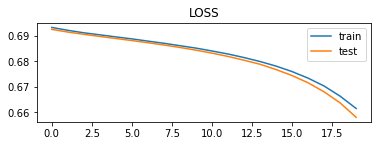

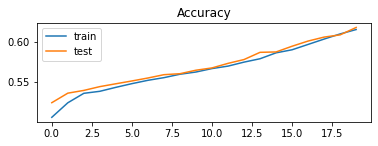

In [240]:
plt.subplot(211)
plt.title("LOSS")
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.subplot(211)
plt.title("Accuracy")
plt.plot(model_history.history['accuracy'], label='train')
plt.plot(model_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [242]:
print("-------Test Accuracy-----")
model.evaluate(X_test,y_test)

-------Test Accuracy-----
148/148 [==============================] - 24s 164ms/step - loss: 0.6581 - accuracy: 0.6183


[0.6580747961997986, 0.6182931661605835]

--  Accuracy can be improved when the execution is done for more epochs